In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
from scipy.stats import chi2_contingency, f_oneway
import time

#For feature engineering
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

#Evalution Model
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#Load data
df = pd.read_csv('data/CustomerLabels.csv')
df.head()

,customer,recency,frequency,monetary,country,R,F,M,group,cluster,labels
0,12940,54,2,899.69,United Kingdom,2,2,3,223,4,LIKELY GONE
1,13285,22,4,2709.12,United Kingdom,3,3,4,334,1,PROSPECTIVE
2,13623,30,5,727.74,United Kingdom,3,3,3,333,4,LIKELY GONE
3,13832,18,1,52.20,United Kingdom,3,1,1,311,0,NEW
4,14450,180,3,483.25,United Kingdom,1,3,2,132,4,LIKELY GONE


In [3]:
#Drop unwanted columns
df = df[['recency', 'frequency', 'monetary', 'cluster']]
df.describe()

,recency,frequency,monetary,cluster
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,91.536422,4.272015,2048.688084,1.991010
std,100.014169,7.697998,8985.230341,1.411656
min,0.000000,1.000000,3.750000,0.000000
25%,17.000000,1.000000,306.482500,1.000000
50%,50.000000,2.000000,668.570000,2.000000
75%,141.000000,5.000000,1660.597500,3.000000
max,373.000000,209.000000,280206.030000,4.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4338 non-null   int64  
 1   frequency  4338 non-null   int64  
 2   monetary   4338 non-null   float64
 3   cluster    4338 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 135.7 KB


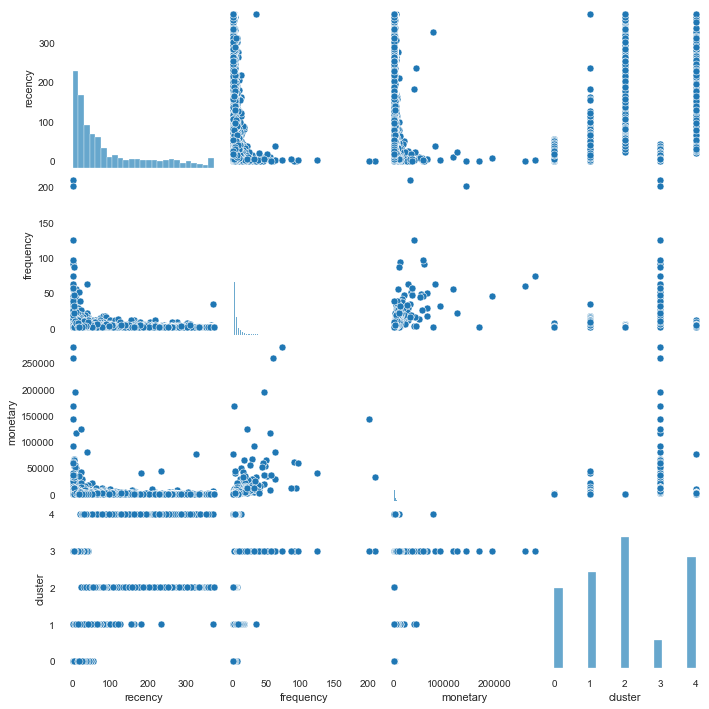

In [5]:
sns.pairplot(df);

In [6]:
#Scale data
data = df.copy()
scaler = RobustScaler()
data[['recency', 'frequency', 'monetary']] = scaler.fit_transform(data[['recency', 'frequency', 'monetary']])
df.describe()

,recency,frequency,monetary,cluster
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,91.536422,4.272015,2048.688084,1.991010
std,100.014169,7.697998,8985.230341,1.411656
min,0.000000,1.000000,3.750000,0.000000
25%,17.000000,1.000000,306.482500,1.000000
50%,50.000000,2.000000,668.570000,2.000000
75%,141.000000,5.000000,1660.597500,3.000000
max,373.000000,209.000000,280206.030000,4.000000


## Time to build model

In [7]:
#Split X, y
X = data.copy()
y = X.pop('cluster')
#Split train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=0)
#CV split
# run model 10x with 70/20 split intentionally leaving out 10%
cv_split = ShuffleSplit(n_splits = 5, test_size = .2,
                        train_size = .7, random_state = 0)

In [8]:
param_grids = [
    #Random Forest
    {'n_estimators': [50, 100, 150, 250],
     'criterion': ['gini', 'entropy']},

    #KNN
    {'n_neighbors': list(range(2,20))},

    #LogisticRegression
    {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},

    #GausianNB
    {},

    #SVC
    {'C': [1, 10, 100],
     'gamma': [0.01, 0.1, 0.25, 0.75]},

    #Decision Tree
    {'max_depth': [4, 6, 8, 10, None],
     'criterion': ['gini', 'entropy']}
]

MLA = [
    RandomForestClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    GaussianNB(),
    SVC(),
    DecisionTreeClassifier()
]

In [9]:
scoring = pd.DataFrame(columns=['algorithm', 'best_params', 'score_train', 'score_test', 'fit_time'])
row = 0

start_total = time.perf_counter()
for mla, param in zip(MLA, param_grids):
    gscv = GridSearchCV(mla, param, cv = cv_split, return_train_score=True, n_jobs=4)
    gscv.fit(X,y)

    best_index = gscv.best_index_
    scoring.loc[row, 'algorithm'] = gscv.best_estimator_.__class__.__name__
    scoring.loc[row, 'best_params'] = str(gscv.best_params_)
    scoring.loc[row, 'score_train'] = gscv.cv_results_['mean_train_score'][best_index]
    scoring.loc[row, 'score_test'] = gscv.cv_results_['mean_test_score'][best_index]
    scoring.loc[row, 'fit_time'] = gscv.cv_results_['mean_fit_time'][best_index]
    row+=1

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

Total optimization time was 0.34 minutes.


In [10]:
scoring.sort_values(by = 'score_test', ascending=False)

,algorithm,best_params,score_train,score_test,fit_time
4,SVC,"{'C': 100, 'gamma': 0.75}",0.992292,0.982719,0.081382
0,RandomForestClassifier,"{'criterion': 'gini', 'n_estimators': 50}",1.0,0.979954,0.144213
5,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': None}",1.0,0.958065,0.00738
1,KNeighborsClassifier,{'n_neighbors': 7},0.966733,0.952535,0.00359
2,LogisticRegression,{'solver': 'newton-cg'},0.938933,0.941014,0.09754
3,GaussianNB,{},0.874901,0.885023,0.00359


We can see, the SCV model is giving the best score, nearly 100%, also the fit time is quite low.

## Evaluate model

In [11]:
#Create best model
best_model = SVC(C=100, gamma=0.25)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
#Print classification report
print("Classification report:\n" + classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.95      0.99      0.97       181
           2       0.99      0.99      0.99       271
           3       0.98      0.89      0.93        55
           4       0.99      0.97      0.98       214

    accuracy                           0.98       868
   macro avg       0.98      0.96      0.97       868
weighted avg       0.98      0.98      0.98       868



# Create pipeline

In [12]:
pipeline = Pipeline(steps=[
                ('scaler', RobustScaler()),
                ('clf', SVC(C=100, gamma=0.25))
                           ])

In [13]:
X = df.copy()
y = X.pop('cluster')
pipeline.fit(X, y)

Pipeline(steps=[('scaler', RobustScaler()), ('clf', SVC(C=100, gamma=0.25))])

In [14]:
y_pred = pipeline.predict(X)
#Print classification report
print("Classification report:\n" + classification_report(y, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       775
           1       0.99      0.99      0.99       933
           2       0.99      1.00      0.99      1269
           3       0.99      0.96      0.97       278
           4       0.99      0.98      0.99      1083

    accuracy                           0.99      4338
   macro avg       0.99      0.98      0.99      4338
weighted avg       0.99      0.99      0.99      4338



In [15]:
#Save pipeline
import pickle

pickle.dump(pipeline, open('model/classification_pipeline.pkl', 'wb'))

In [16]:
pipeline.predict(X.iloc[:5])

array([4, 1, 4, 0, 4], dtype=int64)

In [17]:
test = X.iloc[:5]
test

,recency,frequency,monetary
0,54,2,899.69
1,22,4,2709.12
2,30,5,727.74
3,18,1,52.20
4,180,3,483.25


In [18]:
pipeline.predict([[20, 12, 15000]])

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=int64)